In [1]:
import cv2
import numpy as np
from path import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch

from midas.model_loader import load_model
import utils
from run import process


## 在文件夹下计算评估指标

In [2]:

def RMSE_f(gt,pred):
    return np.sqrt(np.mean( (gt-pred)**2 ))

def L1_f(gt,pred):
    return np.mean(abs(gt-pred))


def get_scale(pred_path,gt_path):
    """scale in paper SimCol3D

    Args:
        pred_path (_type_): _description_
        gt_path (_type_): _description_

    Returns:
        _type_: _description_
    """
    pred_imgs = sorted(pred_path.listdir("*.png"))
    gt_imgs = sorted(gt_path.listdir("*.npy"))
    
    sum1,sum2 = 0.0,0.0 # 分子 分母
    for p1,p2 in zip(pred_imgs,gt_imgs):
        pred_depth = 1-1.0*cv2.imread(p1,-1)/65535.0
        gt_depth = np.load(p2)
        mean1,mean2 = pred_depth.mean(), gt_depth.mean()
        sum1 += mean1*mean2
        sum2 += mean1*mean1
    return sum1/sum2

### 评估所有的 scenes

In [8]:
# 评估所有的scene

scenes = []
for t in Path("/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth").listdir():
    if t.isdir(): scenes.append(t)
print(scenes)

scene = "scene_cecum_t1_a"
scene = "scene_cecum_t1_b"
scene = "scene_cecum_t2_a"

RMSEs_of_scenes, MAEs_of_scenes = [], []
for scene in tqdm(scenes):
    pred_path = scene/'output_monodepth'
    gt_path = scene/'depth_gt'
    scale = get_scale(pred_path,gt_path)
    RMSEs, MAEs = [], []
    pred_imgs = sorted(pred_path.listdir("*.png"))
    gt_imgs = sorted(gt_path.listdir("*.npy"))

    sum1,sum2 = 0.0,0.0 # 分子 分母
    for p1,p2 in zip(pred_imgs,gt_imgs):
        pred_depth = 1-cv2.imread(p1,-1)/65535
        pred_depth *= scale
        gt_depth = np.load(p2)
        RMSEs.append(RMSE_f(gt_depth,pred_depth))
        MAEs.append(L1_f(gt_depth,pred_depth))
    RMSEs_of_scenes.append(RMSEs)
    MAEs_of_scenes.append(MAEs)

[Path('/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_trans_t2_b'), Path('/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_a'), Path('/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_trans_t2_a'), Path('/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_trans_t1_a'), Path('/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_trans_t2_c'), Path('/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_trans_t4_a'), Path('/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_trans_t3_a'), Path('/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_trans_t3_b'), Path('/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_trans_t1_b'), Path('/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_b'), Path('/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t2_a')]


100%|██████████| 11/11 [01:04<00:00,  5.88s/it]


In [13]:
sum_RMSE,sum_MAE,length = 0.0,0.0, 0
trans_RMSE,trans_MAE,trans_length = 0.0,0.0, 0
cecum_RMSE,cecum_MAE,cecum_length = 0.0,0.0, 0

for scene,RMSEs,MAEs in zip(scenes,RMSEs_of_scenes,MAEs_of_scenes):
    name = scene.split('/')[-1]
    print("\n", name)
    print("=> RMSE is ",sum(RMSEs)/len(RMSEs),'mm')
    print("=> MAE is ", sum(MAEs)/len(MAEs), 'mm')
    
    sum_RMSE += sum(RMSEs)
    sum_MAE += sum(MAEs)
    length += len(RMSEs)
    if 'trans' in name:
        trans_RMSE += sum(RMSEs)
        trans_MAE += sum(MAEs)
        trans_length += len(RMSEs)
    elif 'cecum' in name:
        cecum_RMSE += sum(RMSEs)
        cecum_MAE += sum(MAEs)
        cecum_length += len(RMSEs)

print("\n[trans] avg RMSE is ", trans_RMSE/trans_length,'mm')
print("[trans] avg MAE is ", trans_MAE/trans_length,'mm')
print("\n[cecum] avg RMSE is ", cecum_RMSE/cecum_length,'mm')
print("[cecum] avg MAE is ", cecum_MAE/cecum_length,'mm')

print("\n!!!avg RMSE of all scenes is ", sum_RMSE/length,'mm')
print("\n!!!avg MAE of all scenes is ", sum_MAE/length,'mm')


 scene_trans_t2_b
=> RMSE is  6.059581387294265 mm
=> MAE is  4.071980248182267 mm

 scene_cecum_t1_a
=> RMSE is  7.93005938431118 mm
=> MAE is  6.2448009532065765 mm

 scene_trans_t2_a
=> RMSE is  5.5358145740081035 mm
=> MAE is  4.005059404458894 mm

 scene_trans_t1_a
=> RMSE is  5.759531253418149 mm
=> MAE is  4.023443574286506 mm

 scene_trans_t2_c
=> RMSE is  7.467220268651829 mm
=> MAE is  6.229624649286646 mm

 scene_trans_t4_a
=> RMSE is  5.70941966214836 mm
=> MAE is  4.634237742069592 mm

 scene_trans_t3_a
=> RMSE is  3.815791546572946 mm
=> MAE is  2.8219745439631803 mm

 scene_trans_t3_b
=> RMSE is  4.980500211119362 mm
=> MAE is  3.5960894952432256 mm

 scene_trans_t1_b
=> RMSE is  4.449937641256943 mm
=> MAE is  3.4083185689628714 mm

 scene_cecum_t1_b
=> RMSE is  9.097425091459197 mm
=> MAE is  7.673536136325415 mm

 scene_cecum_t2_a
=> RMSE is  7.031611153145184 mm
=> MAE is  5.759201802305259 mm

[trans] avg RMSE is  5.198664175541786 mm
[trans] avg MAE is  3.99109207

### 每个scene评估

In [15]:
RMSEs, MAEs = [], []
pred_imgs = sorted(pred_path.listdir("*.png"))
gt_imgs = sorted(gt_path.listdir("*.npy"))

sum1,sum2 = 0.0,0.0 # 分子 分母
for p1,p2 in zip(pred_imgs,gt_imgs):
    pred_depth = 1-cv2.imread(p1,-1)/65535
    pred_depth *= scale
    gt_depth = np.load(p2)
    RMSEs.append(RMSE_f(gt_depth,pred_depth))
    MAEs.append(L1_f(gt_depth,pred_depth))

=> RMSE is  7.031611153145184 mm
=> MAE is  5.759201802305259 mm


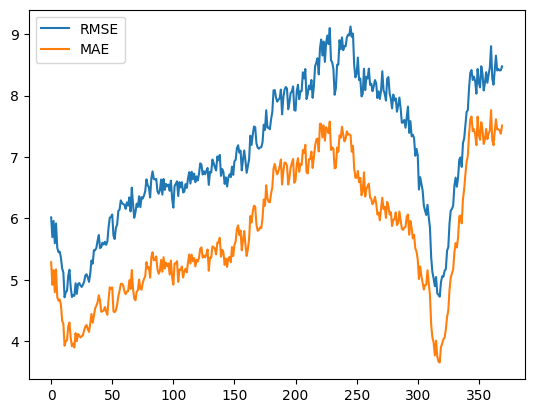

In [17]:
print("=> RMSE is ", sum(RMSEs)/len(RMSEs),'mm')
print("=> MAE is ", sum(MAEs)/len(MAEs),'mm')
plt.plot(RMSEs,label='RMSE')
plt.plot(MAEs,label='MAE')
plt.legend()

## other

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2

from midas.model_loader import load_model
import utils
from run import process


In [ ]:
'''
load model
'''

# 加载微调后的模型
model_type = "dpt_beit_large_512"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: %s" % device)

model_path_finetuing = "/home/jiahan/jiahan/codes/MiDaS/log/11-26-17:22/checkpoints/best.pth.tar"
# model_path_finetuing = "log/11-30-22:02/checkpoints/best.pth.tar" # 使用绝对尺度的损失微调
model_path_finetuing = "log/12-01-20:21/checkpoints/best_0.pth.tar" # 使用 sigmoid 归一化输出的
# model_path_finetuing = "log/11-26-17:22/checkpoints/3.pth.tar"
model_finetuing, transform_finetuing, net_w, net_h = load_model(device, model_path_finetuing, model_type, False, None, None)

model_path_wo_finetuing = "weights/dpt_beit_large_512.pt"
model_wo_finetuing, transform__wo_finetuing, net_w, net_h = load_model(device, model_path_wo_finetuing, model_type, False, None, None)

In [3]:

'''
load data
'''

# img_path = "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/00000.jpg"
# img_path = "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/00007.jpg"
img_path = "/home/jiahan/jiahan/datasets/Ours/scenes/scene1/0000029.png"

ori_image = utils.read_image(img_path)
image = transform_finetuing({"image": ori_image})["image"] # jh in [-1, 1]

print(ori_image.shape[1::-1])
print(net_w, net_h)

(672, 512)
512 512


## 对比微调的效果

In [5]:
with torch.no_grad():
    prediction_wo_finetuing = process(device, model_wo_finetuing, model_type, image, (net_w, net_h), ori_image.shape[1::-1],
                                     False, False)

    prediction_finetuing = process(device, model_finetuing, model_type, image, (net_w, net_h), ori_image.shape[1::-1],
                                     False, False)

NameError: name 'model_wo_finetuing' is not defined

In [9]:
gt = cv2.imread("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/output_monodepth/00007-dpt_beit_large_512.png", -1)

prediction_wo_finetuing_norm = (prediction_wo_finetuing-prediction_wo_finetuing.min())/(prediction_wo_finetuing.max()-prediction_wo_finetuing.min())
prediction_finetuing_norm = (65535*prediction_wo_finetuing_norm).astype(np.uint16)
cv2.imwrite("./tmp.png",prediction_finetuing_norm)

prediction_finetuing_norm = cv2.imread("./tmp.png",-1)
print((gt.astype(np.float32)-prediction_finetuing_norm.astype(np.float32)).max())

24.0


24214.768 0.0 20427.578


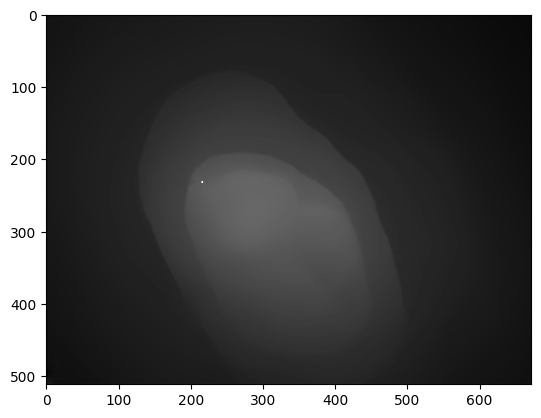

In [10]:
print(prediction_finetuing.max(), prediction_finetuing.min(), prediction_finetuing.mean())
prediction_finetuing_norm = (prediction_finetuing-prediction_finetuing.min())/(prediction_finetuing.max()-prediction_finetuing.min())

# plt.imshow(1/(1e3*prediction_finetuing_norm+1),cmap='gray')
plt.imshow(1-prediction_finetuing_norm,cmap='gray')

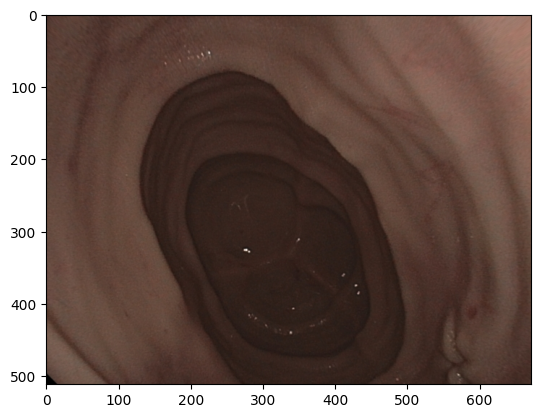

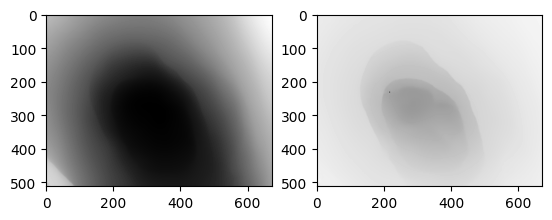

In [11]:
plt.figure()
plt.imshow(ori_image)

plt.figure()

plt.subplot(1,2,1)
plt.imshow((prediction_wo_finetuing-prediction_wo_finetuing.min())/(prediction_wo_finetuing.max()-prediction_wo_finetuing.min()), cmap='gray')

plt.subplot(1,2,2)
plt.imshow((prediction_finetuing-prediction_finetuing.min())/(prediction_finetuing.max()-prediction_finetuing.min()), cmap='gray')

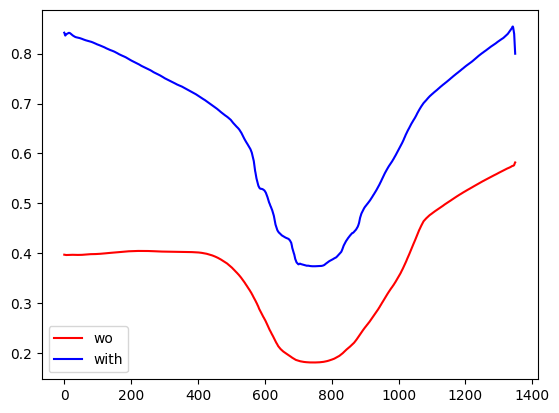

In [15]:
prediction_wo_finetuing_norm = (prediction_wo_finetuing-prediction_wo_finetuing.min())/(prediction_wo_finetuing.max()-prediction_wo_finetuing.min())
prediction_finetuing_norm = (prediction_finetuing-prediction_finetuing.min())/(prediction_finetuing.max()-prediction_finetuing.min())
plt.plot(prediction_wo_finetuing_norm[300], color='r', label='wo')
plt.plot(prediction_finetuing_norm[300], color='b', label='with')
plt.legend()

## 查看网络的预测深度图

In [3]:
def align(pred, gt):
    h,w = gt.shape
    p1,p2 = (200,200), (600,600) # 选取求解点
    
    d1,d2 = gt[p1[1],p1[0]], gt[p2[1],p2[0]]
    d1_,d2_ = pred[p1[1],p1[0]], pred[p2[1],p2[0]]

    # 解方程
    A = np.ones((h*w,2))
    A[::,0] = pred.flatten()
    b = np.ones((h*w,1))
    b[::,0] = gt.flatten()
    x = np.linalg.inv(A.T@A)@A.T@b
    
    # A = np.array([
    #     [d1_,1],
    #     [d2_,1]
    # ])
    # b = np.array([
    #     [d1],
    #     [d2]
    # ])
    # x = np.linalg.inv(A) @ b
    
    alpha, beta = x[0][0], x[1][0]

    depth_midas = alpha*pred + beta
    print("alpha and beta are ", alpha, beta)
    return depth_midas

def RMSE_f(gt,pred):
    return np.sqrt(np.mean( (gt-pred)**2 ))

def L1_f(gt,pred):
    return np.mean(abs(gt-pred))

def error_map_f(gt,pred, display=True):
    error_map = abs(gt.astype(np.float32)-pred.astype(np.float32))
    if display:
        print("> error map")
        print("=> max is ",error_map.max(), "\n=> mean is ",error_map.mean(), "\n=> min is ",error_map.min())
    return error_map

def save_pointcloud(pointcloud, save_file):
    pointclouds = [pointcloud]
    with open(save_file,'w') as f:
        for pointcloud in pointclouds:
            for t in pointcloud.reshape((3,-1)).T:
                line = "{},{},{}\n".format(t[0],t[1],t[2])
                f.write(line)
    return 

def unproj(K,depth,img):
    h,w,_ = img.shape
    x,y = np.meshgrid(np.linspace(0,w-1,w), np.linspace(0,h-1,h))
    x,y = x[None,...], y[None,...]
    z = np.ones((1,h,w))
    
    coor = np.concatenate((x,y,z),axis=0).reshape((3,-1))
    
    K_inv = np.linalg.inv(K)
    coor_camera = K_inv @ coor # 相机坐标
    
    coor_camera = coor_camera.reshape((3,h,w))
    coor_camera[0,...] *= depth
    coor_camera[1,...] *= depth
    coor_camera[2,...] *= depth
    
    return coor_camera

def save_depthmap(depth,save_file):
    cv2.imwrite(save_file, depth, [cv2.IMWRITE_PNG_COMPRESSION, 0])


In [ ]:
'''
load model
'''

# 加载微调后的模型
model_type = "dpt_beit_large_512"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: %s" % device)

# model_path_finetuing = "/home/jiahan/jiahan/codes/MiDaS/weights/dpt_beit_large_512.pt"
# model_path_finetuing = "/home/jiahan/jiahan/codes/MiDaS/log/11-26-17:22-GOLDEN/checkpoints/best.pth.tar"
# model_path_finetuing = "log/11-30-22:02/checkpoints/best.pth.tar" # 使用绝对尺度的损失微调
# model_path_finetuing = "log/12-01-20:21/checkpoints/40.pth.tar" # 使用sigmoid 归一化输出
# model_path_finetuing = "log/12-05-18:55/checkpoints/best_1.pth.tar" # 使用sigmoid 归一化输出
# model_path_finetuing = "log/11-26-17:22/checkpoints/3.pth.tar"

model_path_finetuing = "log/SimCol3D/01-20-17:25/checkpoints/0.pth.tar" # SimCol3D
model_finetuing, transform_finetuing, net_w, net_h = load_model(device, model_path_finetuing, model_type, False, None, None)



In [5]:


# img_path = "/home/jiahan/jiahan/datasets/T1/C_T1_L2_1_resized/FrameBuffer_0295.png"
# img_path = "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4NiceSLAM/frames/color/216.jpg"
# img_path = "/home/jiahan/jiahan/datasets/scenes/scene1/0002686.jpg"

img_path = "/home/jiahan/jiahan/datasets/Ours/scenes/scene1/0000042.png"
# img_path = "/home/jiahan/jiahan/datasets/Ours/scenes/scene1/0000098.png"
# img_path = "/home/jiahan/jiahan/datasets/Ours/scenes/scene2/0000207.png"
# img_path = "/home/jiahan/jiahan/datasets/Ours/scenes/scene2/0000005.png"
# img_path = "/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_trans_t2_a/00048.jpg"
gt = cv2.imread("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4NiceSLAM/frames/depth_gt/216.png", -1)/65535
depth2 = cv2.imread("/home/jiahan/jiahan/datasets/C3VD/MiDas_Depth/cecum_t1_a_finetuing/216-dpt_beit_large_512.png", -1)/65535

ori_image = utils.read_image(img_path)
image = transform_finetuing({"image": ori_image})["image"] # jh in [-1, 1]

with torch.no_grad():
    pred = process(device, model_finetuing, model_type, image, (net_w, net_h), ori_image.shape[1::-1],
                                     False, False)
# pred = process(device, model_finetuing, model_type, image, (net_w, net_h), ori_image.shape[1::-1],False, False).detach()

pred = 1-(pred-pred.min())/(pred.max()-pred.min())

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

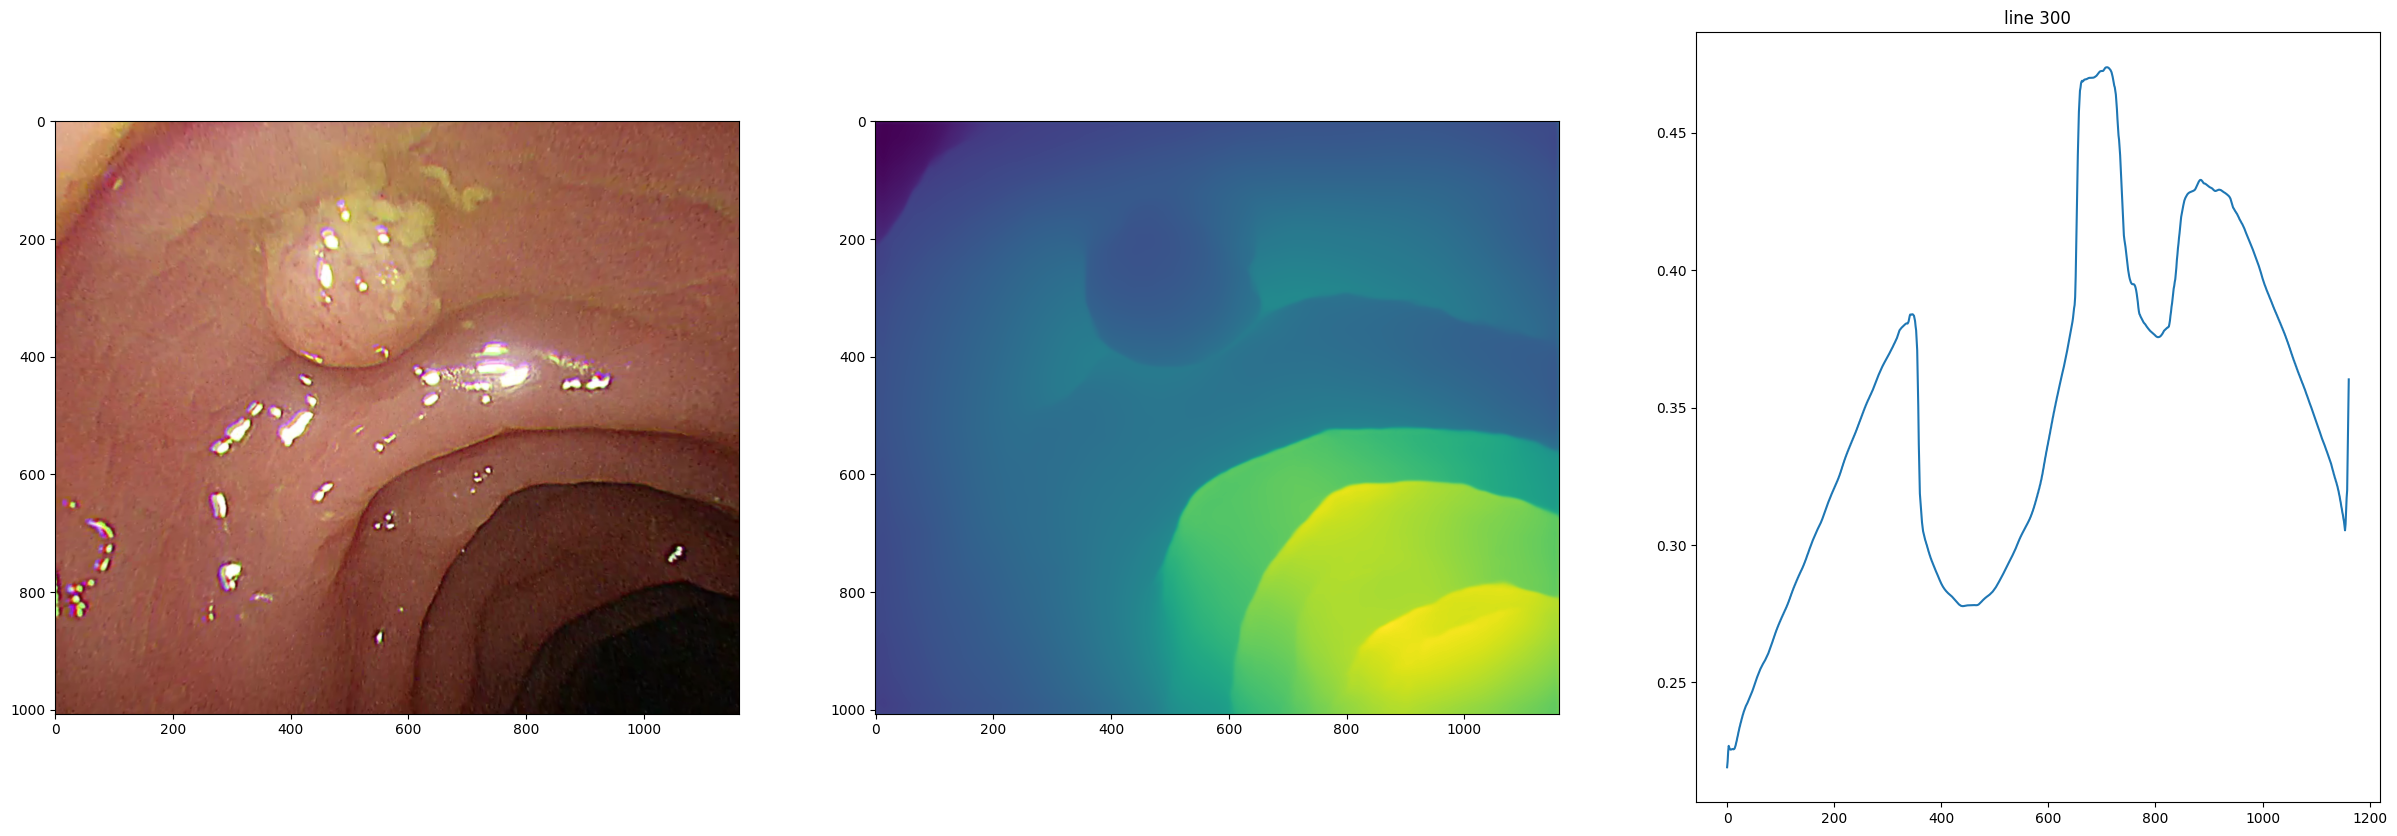

In [53]:
# 展示图像
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(plt.imread(img_path))
plt.subplot(1,3,2)
plt.imshow(pred)
plt.subplot(1,3,3)
plt.title("line 300")
plt.plot(pred[300])

In [19]:

output = torch.sigmoid((torch.from_numpy(pred)-5000)/10000.0)
# output = 1-output
print(output.max(),output.min(),output.mean())

tensor(0.9546) tensor(0.7415) tensor(0.8285)


In [20]:
print(pred.max(),pred.min(),pred.mean())

# pred_norm = 1- (pred-pred.min())/(pred.max()-pred.min())
pred_norm = 1 - output
depth2 = 1-depth2
# pred_norm = (pred-pred.min())/(pred.max()-pred.min())

35453.117 15537.166 21317.562


### 在SimCol数据集上推理

test 划分如下所示

SyntheticColon_I/Frames_S5/

SyntheticColon_I/Frames_S10/

SyntheticColon_I/Frames_S15/

SyntheticColon_II/Frames_B5/

SyntheticColon_II/Frames_B10/

SyntheticColon_II/Frames_B15/

SyntheticColon_III/Frames_O1/

SyntheticColon_III/Frames_O2/

SyntheticColon_III/Frames_O3/

In [17]:


from path import Path

def list_dataset_SimCol3D(scene):
    frames = sorted(scene.listdir("FrameBuffer_*.png"))
    depths = sorted(scene.listdir("Depth_*.png"))
    return frames, depths

def list_dataset_C3VD(scene):
    frames = sorted(scene.listdir("*.jpg"))
    depths = sorted((scene/'depth_gt').listdir("*.npy"))
    return frames,depths

# C3VD
# root_path = Path("/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth")
# scenes = sorted(root_path.listdir("scene*"))
# SimCol3D
# root_path = Path("/home/jiahan/jiahan/datasets/SimCol/SyntheticColon_III/SyntheticColon_III")
root_path = Path("/home/jiahan/jiahan/datasets/SimCol/SyntheticColon_II/SyntheticColon_II")
# root_path = Path("/home/jiahan/jiahan/datasets/SimCol/SyntheticColon_I/SyntheticColon_I")
# scenes = root_path.listdir()
scenes = [
    root_path/"Frames_B5",
    root_path/"Frames_B10",
    root_path/"Frames_B15"
]

img_paths = []
depth_paths = []
for scene in scenes:
    if not scene.isdir(): continue
    frames,depths = list_dataset_SimCol3D(scene)
    # frames,depths = list_dataset_C3VD(scene)
    # frames = sorted(scene.listdir("FrameBuffer_*.png"))
    # depths = sorted(scene.listdir("Depth_*.png"))
    img_paths += frames
    depth_paths += depths



/home/jiahan/jiahan/datasets/SimCol/SyntheticColon_II/SyntheticColon_II/Frames_B5/Depth_0000.png
/home/jiahan/jiahan/datasets/SimCol/SyntheticColon_II/SyntheticColon_II/Frames_B5/FrameBuffer_0000.png


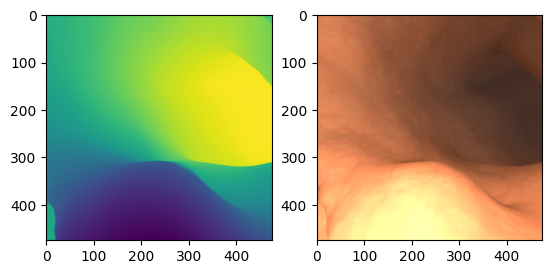

In [20]:
print(depth_paths[0])
print(img_paths[0])

ori_image = utils.read_image(img_paths[0])
image = transform_finetuing({"image": ori_image})["image"] # jh in [-1, 1]
with torch.no_grad():
    pred = process(device, model_finetuing, model_type, image, (net_w, net_h), ori_image.shape[1::-1],
                                         False, False)
pred = 1-(pred-pred.min())/(pred.max()-pred.min())
plt.subplot(1,2,1)
plt.imshow(pred)
plt.subplot(1,2,2)
plt.imshow(ori_image)

In [21]:
from tqdm import tqdm, trange

def read_depth_SimCol3D(depth_path):
    return 200*cv2.imread(depth_path,-1)/65535
def read_depth_C3VD(depth_path):
    tmp = np.load(depth_path)
    return tmp/100.0

RMSEs, MAEs = [], []
for i in trange(len(img_paths)):
# for i in trange(100):
    ori_image = utils.read_image(img_paths[i])
    image = transform_finetuing({"image": ori_image})["image"] # jh in [-1, 1]
    with torch.no_grad():
        pred = process(device, model_finetuing, model_type, image, (net_w, net_h), ori_image.shape[1::-1],
                                         False, False)
    pred = 1-(pred-pred.min())/(pred.max()-pred.min())

    depth_gt = read_depth_SimCol3D(depth_paths[i])
    # depth_gt = read_depth_C3VD(depth_paths[i])
    
    ratio = np.median(depth_gt)/np.median(pred)
    RMSEs.append(RMSE_f(depth_gt,pred*ratio))
    MAEs.append(L1_f(depth_gt,pred*ratio))

100%|██████████| 3603/3603 [16:50<00:00,  3.57it/s]


=> RMSE mean is 
0.3752536643562825
=> MAE mean is 
0.30856562915440955


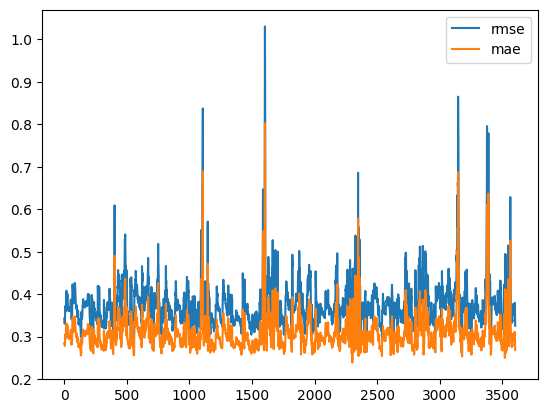

In [23]:

import matplotlib.pyplot as plt
# depth_gt = cv2.imread(depth_paths[i],-1)/65535
# plt.imshow(depth_gt)
plt.plot(RMSEs,label='rmse')
plt.plot(MAEs,label='mae')
plt.legend()
print("=> RMSE mean is ")
print(sum(RMSEs)/len(RMSEs))
print("=> MAE mean is ")
print(sum(MAEs)/len(MAEs))

### 投影成点云

In [43]:
# 内参
fx,fy = 719.79491, 719.83461
cx,cy = 576.49010, 507.60611
K = np.array([
    [fx,0,cx],
    [0,fy,cy],
    [0,0,1]
])

In [63]:
from path import Path

save_path = Path("./point_clouds")
save_path.makedirs_p()

pointcloud = unproj(K,pred,ori_image)
save_name = img_path.split('/')[-1][:-4]
save_file = save_path/"{}.asc".format(save_name)
print("== will be saved at savename")
save_pointcloud(pointcloud, save_file)

plt.imsave(save_path/"{}.png".format(save_name), plt.imread(img_path))
save_depthmap((pred*65535).astype(np.uint16),save_path/"{}_depth.png".format(save_name))

== will be saved at savename


### tmp


    Input resized to 448x512 before entering the encoder
    Input resized to 512x512 before entering the encoder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


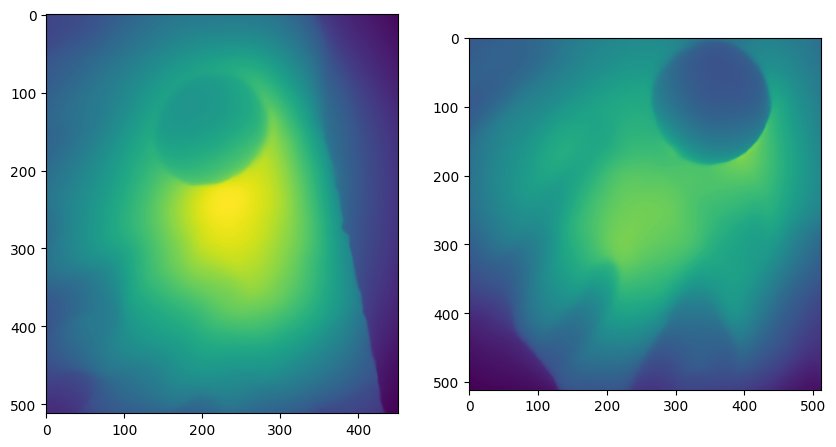

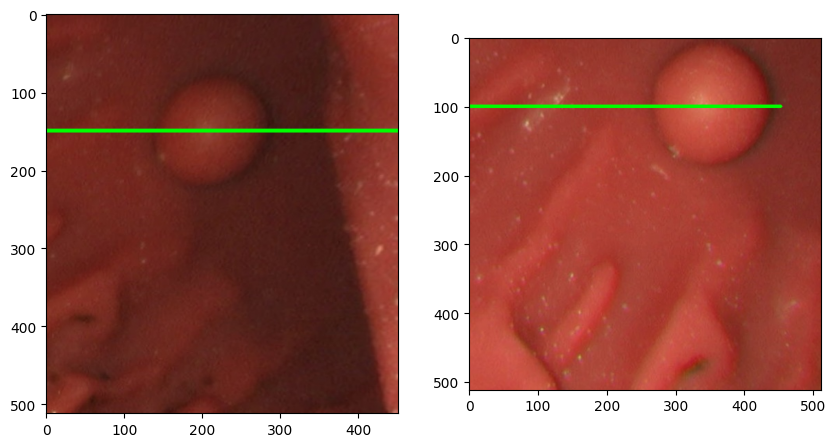

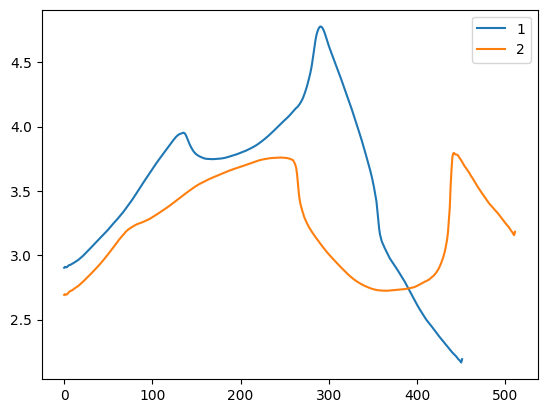

In [46]:
img1_path = "/home/jiahan/jiahan/datasets/scenes/scene1/0002605.jpg"
img2_path = "/home/jiahan/jiahan/datasets/scenes/scene1/0002686.jpg"


ori_img1,ori_img2 = utils.read_image(img1_path), utils.read_image(img2_path)

ori_img1 = ori_img1[100:100+512,700:700+512]
ori_img2 = ori_img2[200:200+512,300:300+512]

image1, image2 = transform_finetuing({"image": ori_img1})["image"], transform_finetuing({"image": ori_img2})["image"] # jh in [-1, 1]
with torch.no_grad():
    pred1 = process(device, model_finetuing, model_type, image1, (net_w, net_h), ori_img1.shape[1::-1],
                                     False, False)
with torch.no_grad():
    pred2 = process(device, model_finetuing, model_type, image2, (net_w, net_h), ori_img2.shape[1::-1],
                                     False, False)

pred1 = (1-torch.sigmoid((torch.from_numpy(pred1)-5000)/10000.0).numpy()) * 20
pred2 = (1-torch.sigmoid((torch.from_numpy(pred2)-5000)/10000.0).numpy()) * 20

line1, line2 = 150,100
h,w,_ = ori_img1.shape

cv2.line(ori_img1,(0,line1),(w,line1),(0,255,0),3)
cv2.line(ori_img2,(0,line2),(w,line2),(0,255,0),3)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
# plt.imshow(pred1, vmin=0,vmax=20)
plt.imshow(pred1)
plt.subplot(1,2,2)
# plt.imshow(pred2, vmin=0,vmax=20)
plt.imshow(pred2)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(ori_img1)
plt.subplot(1,2,2)
plt.imshow(ori_img2)

plt.figure()
plt.plot(pred1[line1],label='1')
plt.plot(pred2[line2],label='2')
plt.legend()

np.save("0002605.npy",pred1)
np.save("0002686.npy",pred2)

### 2. 1

tensor(0.2585) tensor(0.0454) tensor(0.1715)
alpha and beta are  0.5552413706387965 0.11634515029334619


ValueError: could not broadcast input array from shape (1142784,) into shape (1458000,)

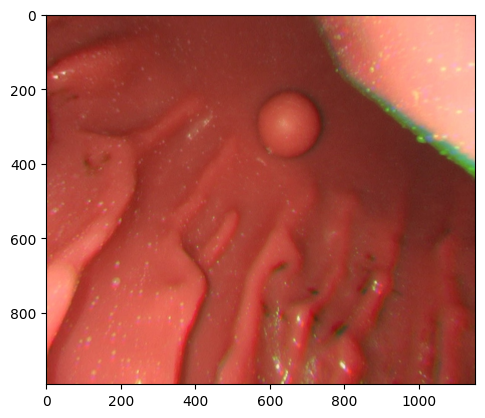

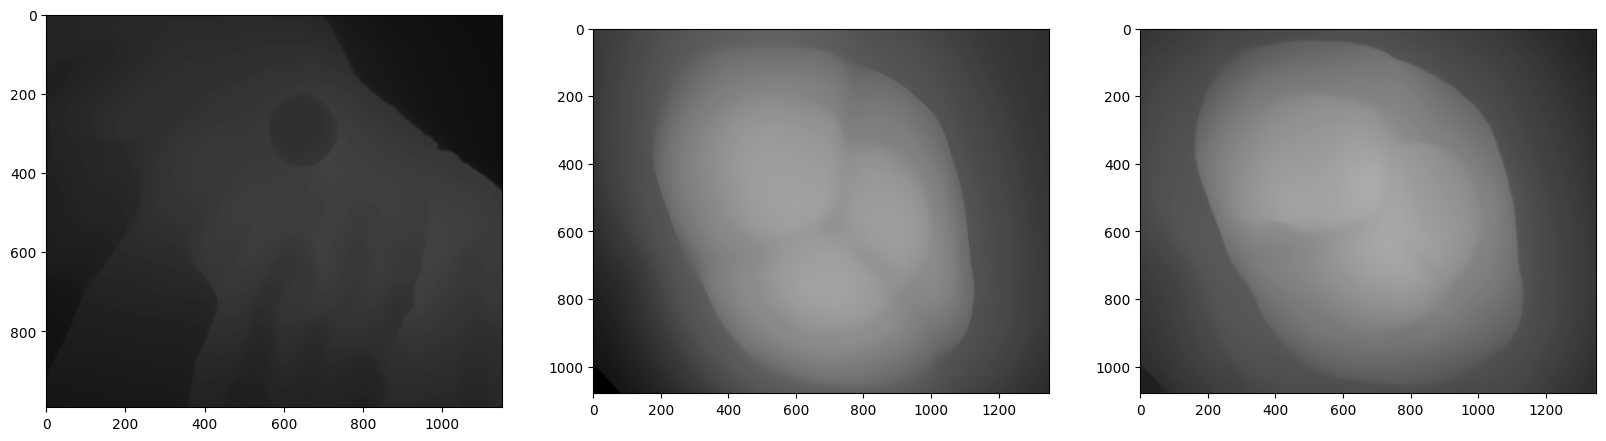

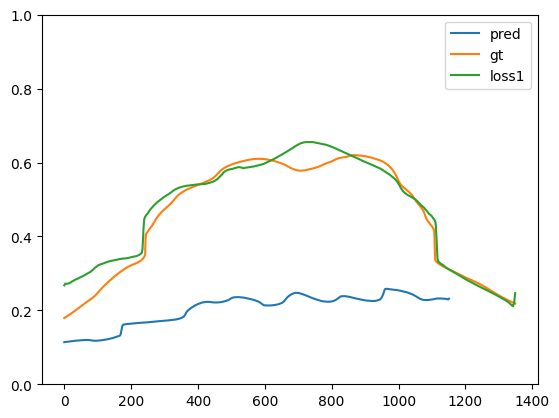

In [21]:
print(pred_norm.max(),pred_norm.min(),pred_norm.mean())

depth2 = align(depth2,gt)

plt.figure()
plt.imshow(ori_image)

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(pred_norm,cmap='gray',vmin=0,vmax=1)
plt.subplot(1,3,2)
plt.imshow(gt,cmap='gray',vmin=0,vmax=1)
plt.subplot(1,3,3)
plt.imshow(depth2,cmap='gray',vmin=0,vmax=1)

plt.figure()
line = 600
plt.ylim(0,1)
plt.plot(pred_norm[line],label='pred')
plt.plot(gt[line],label='gt')
plt.plot(depth2[line],label='loss1')
plt.legend()

pred_align = align(pred_norm,gt)
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title("Loss 2")
plt.imshow(pred_align,cmap='gray',vmin=0,vmax=1)
plt.subplot(1,3,2)
plt.title("GT")
plt.imshow(gt,cmap='gray',vmin=0,vmax=1)
plt.subplot(1,3,3)
plt.title("Loss 1")
plt.imshow(depth2,cmap='gray',vmin=0,vmax=1)

plt.figure()
line = 600
plt.ylim(0,1)
plt.plot(pred_align[line],label='pred')
plt.plot(gt[line],label='gt')
plt.plot(depth2[line],label='loss1')
plt.legend()

print("-------- error loss2 -------")
print("=> RMSE ", RMSE_f(gt,pred_align))
print("=> L1 ", L1_f(gt,pred_align))
error_map = error_map_f(gt,pred_align,True)
plt.figure()
plt.title("error map")
plt.imshow(error_map,cmap='gray',vmin=0,vmax=1)

print("-------- error loss1 -------")
print("=> RMSE ", RMSE_f(gt,depth2))
print("=> L1 ", L1_f(gt,depth2))
error_map = error_map_f(gt,depth2,True)
plt.figure()
plt.title("error map")
plt.imshow(error_map,cmap='gray',vmin=0,vmax=1)

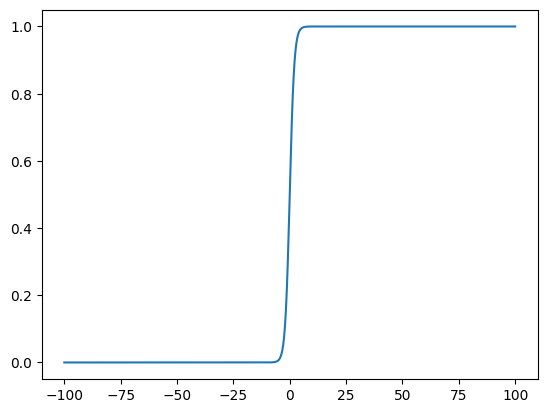

In [20]:
a = np.linspace(-100,100,1000)
y = torch.sigmoid(torch.from_numpy(a))
plt.plot(a,y.numpy())

In [ ]:
'''
探究 DPT max和min值
'''

from path import Path
from tqdm import tqdm

maxs,mins,means = [],[],[]
# imgs = Path("/home/jiahan/jiahan/datasets/T1/C_T1_L2_1_resized").listdir("Frame*.png")
imgs = Path("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1").listdir("*.jpg")
for ip in tqdm(imgs):
    ori_image = utils.read_image(ip)
    image = transform_finetuing({"image": ori_image})["image"] # jh in [-1, 1]
    with torch.no_grad():
        output = process(device, model_wo_finetuing, model_type, image, (net_w, net_h), ori_image.shape[1::-1],
                        False, False)
    
    maxs.append(output.max())
    mins.append(output.min())
    means.append(output.mean())

    

=> maxs avg  7994.8533687867985
=> mins avg  1216.1693924613621
=> means avg  3812.4784616663837


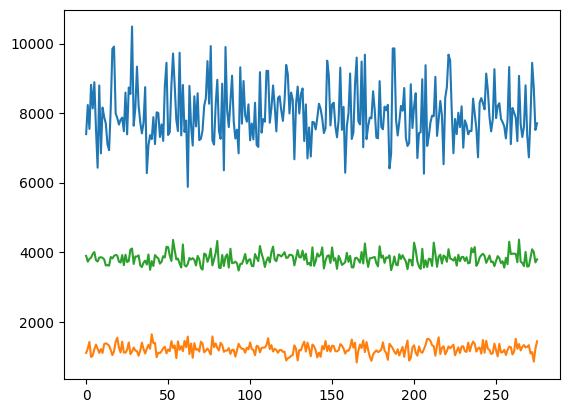

In [30]:
def meanOn(data):
    avg = 0
    for d in data: avg += d
    return avg/len(data)
plt.plot(maxs)
plt.plot(mins)
plt.plot(means)

print("=> maxs avg ", meanOn(maxs))
print("=> mins avg ", meanOn(mins))
print("=> means avg ", meanOn(means))